# FIN 414 - Financial Derivatives
#### Leonardo F. de Souza
#### Dr. James Driver

<hr>
<b>Computer Challenge Problem: Not Required Part of HW (~16 point bonus)</b>
<br>
Download data as instructed below and answer the questions.
<br>
<br>
<i>a.</i> Extract one year’s data on the S&P 500 index from Yahoo (i.e., S&P 500 (^GSPC)
Historical Data - Yahoo Finance). Also download corresponding data for the S&P
100 index (i.e., S&P 100 INDEX (^OEX) Charts, Data & News - Yahoo Finance). For
convenience, use August 2021 through August 2022.
<br>
<i>b.</i> Download, for the same period, data on the 3-month Treasury Bill rate (constant
maturity) from the Federal Reserve’s Web page on historical data:
www.federalreserve.gov/releases/h15/data.htm. (The link redirects to a new
data warehouse.)
<br>
<i>c.</i> Create a data series of 3-month forwards on the S&P 500 index using the index
data and the interest rates you have already extracted. Call this synthetic
forward data series
<br>
<i>d.</i> How would you use this synthetic forwards data to determine the tracking error
of a hedge of 3-month maturity positions in the S&P 100 index? You need to
think about how to set up the time lags of the data and how to define tracking
error.

In [11]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from math import e
import statsmodels.formula.api as smf
from dateutil.relativedelta import relativedelta
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

## Data
#### S&P 500, S&P 100, 3-month T-Bill
###### August 2021 through August 2022

[*********************100%***********************]  2 of 2 completed


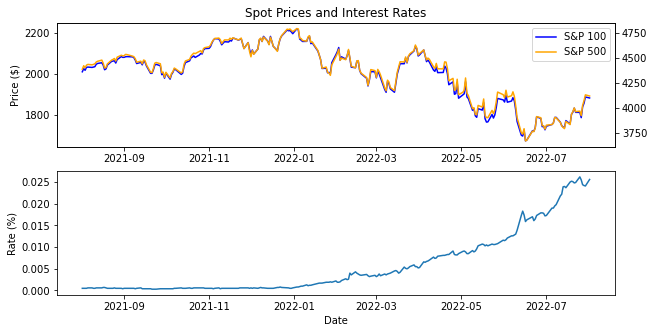

In [2]:
Rates = 'DGS3MO'                #FRED
SP_Tickers = ['^GSPC','^OEX']   #Yahoo! Finance

#August 2021 through August 2022
start = dt.datetime(2021,8,1)
end = dt.datetime(2022,8,1)
interval = '1d'

#3-M Rates
Rates = web.DataReader(Rates, 'fred', start, end)/100
Rates.reset_index('DATE', inplace=True, drop=False)
Rates.dropna(inplace=True)
Rates.rename(columns={'DATE':'Date'}, inplace=True)
#S&P Indices
SP = yf.download(SP_Tickers, interval=interval, start=start)['Adj Close']
SP = pd.DataFrame(SP)
SP.rename(columns={'^GSPC':'SP5', '^OEX':'SP1'}, inplace=True)
# Merge Dataframes
df = pd.merge_asof(Rates, SP, on='Date')

# Plots:
plt.subplot(2, 1, 1)
l1, = plt.plot(df['Date'],df['SP1'], color='blue')
plt.ylabel('Price ($)')
plt.twinx()
l2, = plt.plot(df['Date'],df['SP5'], color='orange')
plt.legend([l1, l2], ['S&P 100', 'S&P 500'])
plt.title('Spot Prices and Interest Rates')
plt.subplot(2, 1, 2)
plt.plot(df['Date'],df['DGS3MO'])
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.show()

<h3>Change in Spot Price and Forward Pricing</h3>
<br>
Remember:
$$
F = S_{0}e^{rT}
$$

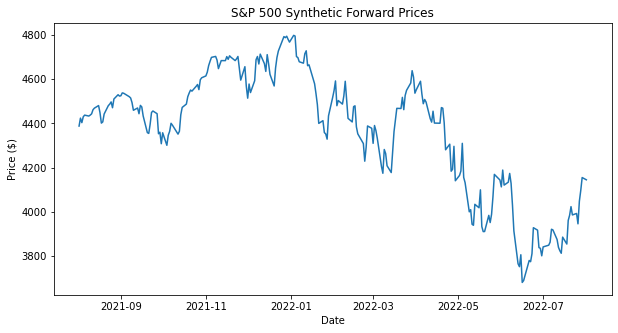

In [3]:
#Change in Spot
df['Delta_SP5']= (df['SP5'].shift(-1) - df['SP5']).shift(1)
df['Delta_SP1']= (df['SP1'].shift(-1) - df['SP1']).shift(1)

# Syntetic Forwards - Using 3-month rate and SPX Index
df['F'] = df['SP5'] * (e**(df['DGS3MO']*0.25))

#Change in Forward
df['Delta_F']= (df['F'].shift(-1) - df['F']).shift(1)

# Plot:
plt.plot(df['Date'],df['F'])
plt.title('S&P 500 Synthetic Forward Prices')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.show()

<h3>Optimal Hedge Ratio ($h^{*}$)</h3>
<br><br>

\begin{align}
h^{*}& = \rho \frac{\sigma (\Delta_{s})}{\sigma (\Delta_{f})} \\ \\
\beta & = \frac{Cov(s,f)}{Var(f)}\\ \\
\therefore \beta & \equiv h^{*}
\end{align}

In [4]:
result = smf.ols(formula='Delta_SP1 ~ Delta_F', data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Delta_SP1   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.809e+04
Date:                Fri, 16 Dec 2022   Prob (F-statistic):          4.71e-233
Time:                        23:19:40   Log-Likelihood:                -627.60
No. Observations:                 249   AIC:                             1259.
Df Residuals:                     247   BIC:                             1266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0550      0.191     -0.287      0.774      -0.432       0.322
Delta_F        0.4702      0.003    134.514      0.000       0.463       0.477
==============================================================================
Omnibus:                        3.421   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.396
Skew:                           0.155   Prob(JB):                        0.183
Kurtosis:                       3.481   Cond. No.                         54.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
print(f"Beta (h*): {round(result.params[1],4)}")

Beta (h*): 0.4702


- The hedge ratio (h*) should be 0.4702

### Data Lags

<h6> 1. New DataFrame (df1 and date) </h6>

In [6]:
df1 = df[['Date', 'SP1']]
date = pd.DataFrame(df['Date'] + pd.DateOffset(months=3)) #adds 3 months
date.columns=['Date']

<h6>2. Lagged DataFrame</h6>
<ol>
  <li>Merge the original dataframe (df) on the date of new dataframe (date) </li>
  <li>SP1 is now the spot price at $t=3$</li>
  <li>$F$ is still the original $F$ and $S_{0}$ is the original SP1 from df</li>
  <li>S0_S is $h^{*} \cdot F$</li>
  <li>Index and Hedge Returns are quarterly rolling returns</li>
  <li>From the regression we know that we should short the S&P 500 Futures ($h^{*}$)</li>
</ol>

In [7]:
df_lag = pd.merge_asof(date, df1, on='Date')
df_lag = df_lag[~(df_lag['Date'] >= end)]
df_lag['F'] = df['F']

# Spot at t=-3
df_lag['S0'] = df['SP1']
#3-M Forward
df_lag['S0_S'] = (result.params[1]*df_lag['F'])

#Index Returns
df_lag['Ret_Index'] = (df_lag['SP1'] - df_lag['S0'])/df_lag['S0']

#Forwards Portfolio Returns
df_lag['Ret_Hedge'] = (df_lag['S0_S']-df_lag['SP1'])/df_lag['S0']

#Hedged Portfolio
df_lag['Hedge Port'] = df_lag['Ret_Hedge'] + df_lag['Ret_Index']

### Charts

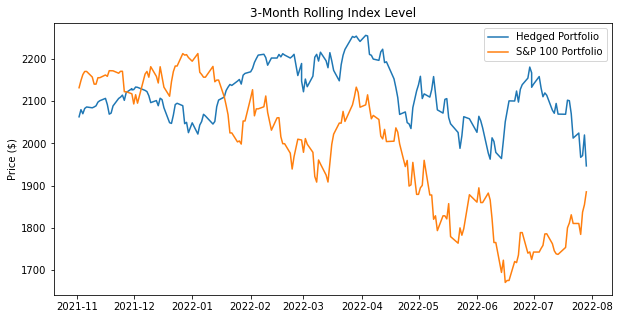

In [8]:
plt.plot(df_lag['Date'],df_lag['S0_S'],df_lag['Date'],df_lag['SP1'])
plt.ylabel('Price ($)')
plt.title('3-Month Rolling Index Level')
plt.legend(['Hedged Portfolio', 'S&P 100 Portfolio'])
plt.show()

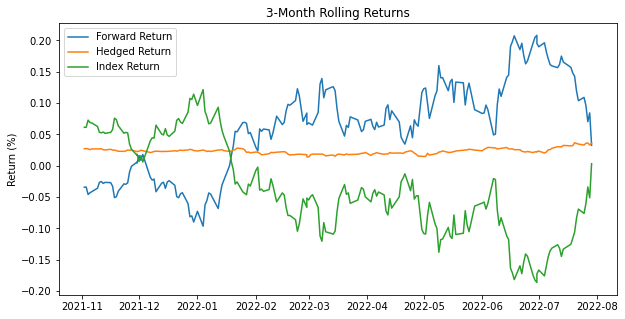

In [9]:
plt.plot(df_lag['Date'], df_lag['Ret_Hedge'],df_lag['Date'], 
         df_lag['Hedge Port'],df_lag['Date'], df_lag['Ret_Index'])
plt.ylabel('Return (%)')
plt.title('3-Month Rolling Returns')
plt.legend(['Forward Return', 'Hedged Return', 'Index Return'])
plt.show()

<h3>Tracking Error</h3>
<br><br>

\begin{align}
TE &= \sqrt{Var(Excess Return)} \\ \\
TE &= \sigma(Excess Return)
\end{align}
<br>
<br>
Calculating excess returns geometrically:

In [12]:
ER = (1+df_lag['Ret_Hedge'])/(1+df_lag['Ret_Index'])-1
TE = ER.std()
print("Tracking Error (Forwards):",f"{round(TE/.0001,2)} bps")
print("Annualized Tracking Error (Forwards):",f"{round((TE*np.sqrt(12))/.0001,2)} bps")

ER = (1+df_lag['Hedge Port'])/(1+df_lag['Ret_Index'])-1
TE = ER.std()
print()
print("Tracking Error (Hedged Portfolio):",f"{round(TE/.0001,2)} bps")
print("Annualized Tracking Error (Hedged Portfolio):",f"{round((TE*np.sqrt(12))/.0001,2)} bps")

Tracking Error (Forwards): 1661.8 bps
Annualized Tracking Error (Forwards): 5756.63 bps

Tracking Error (Hedged Portfolio): 839.78 bps
Annualized Tracking Error (Hedged Portfolio): 2909.08 bps


<hr>
<i> Leonardo F. de Souza </i>
<br>
<i> December 2022</i>